In [1]:
!pip install langgraph langchain langchain-openai langchain_community "httpx==0.27.2"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.8/126.8 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 35.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 40.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.7/409.7 kB 21.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 26.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 2.2 MB/s eta 0:00:00
  Attempting uninstall: httpx
    Found existing installation: httpx 0.28.0
    Uninstalling httpx-0.28.0:
      Successfully uninstalled httpx-0.28.0
  Attempting uninstall: langchain-core
    Found existing installation: langchain-core 0.3.21
    Uninstalling langchain-core-0.3.21:
      Successfully uninstalled langchain-core-0.3.21
  Attempting uninstall: langchain
  

In [2]:
import os
os.environ["OPENAI_API_KEY"] = "sk"

from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o", temperature=0, streaming=True)

In [22]:
from langchain_openai import ChatOpenAI
from langchain.prompts import PromptTemplate
from langchain.chains import RetrievalQA
from langchain.llms import OpenAI

def analyze_question(state): # 사용자 질문을 분석하여 코드 질문인지 일반 질문인지 분류
    llm = ChatOpenAI()
    prompt = PromptTemplate.from_template("""
    당신은 사용자 질문이 기술적인 코드 관련 질문인지 일반적인 질문인지 정의해야 하는 에이전트입니다.
    Question : {input}
    질문을 분석하세요. 질문이 기술적 개발에 관한 것이라면 "code"라고 답변하고, 그렇지 않다면 "general"이라고 답변하세요".
    당신의 답변 (code/general) :
    """)
    chain = prompt | llm
    response = chain.invoke({"input": state["input"]})
    decision = response.content.strip().lower()
    return {"decision": decision, "input": state["input"]}

def code_question(state): # 코드 질문에 대해 단계별로 자세히 답변 생성
    llm = ChatOpenAI()
    prompt = PromptTemplate.from_template(
        "당신은 소프트웨어 엔지니어입니다. 이 질문에 대해 단계별로 자세히 답변하세요 : {input}"
    )
    chain = prompt | llm
    response = chain.invoke({"input": state["input"]})
    return {"output": response}

def general_question(state): # 일반 질문에 대해 간결하고 일반적인 답변 생성
    llm = ChatOpenAI()
    prompt = PromptTemplate.from_template(
        "질문에 대해 일반적이고 간결하게 답변하세요: {input}"
    )
    chain = prompt | llm
    response = chain.invoke({"input": state["input"]})
    return {"output": response}

In [23]:
from langgraph.graph import StateGraph, END
from typing import Annotated, TypedDict

class AgentState(TypedDict):
    input: str
    output: str
    decision: str # 질문의 유형 ("코드 질문" 혹은 "일반 질문").

workflow = StateGraph(AgentState) # 상태 기반 워크플로우 정의

workflow.add_node("analyze", analyze_question) # 질문 유형 분석, analyze_question 함수 실행
workflow.add_node("code_agent", code_question)
workflow.add_node("generic_agent", general_question)

workflow.add_conditional_edges(
    "analyze",
    lambda x: x["decision"], # "analyze" 단계에서 decision 값에 따라 다음 상태로 전이
    {
        "code": "code_agent",
        "general": "generic_agent"
    }
)

workflow.set_entry_point("analyze") # 워크플로우의 시작 노드를 "analyze"로 설정
workflow.add_edge("code_agent", END) # code_agent 단계가 완료되면 워크플로우 종료
workflow.add_edge("generic_agent", END)

graph = workflow.compile()

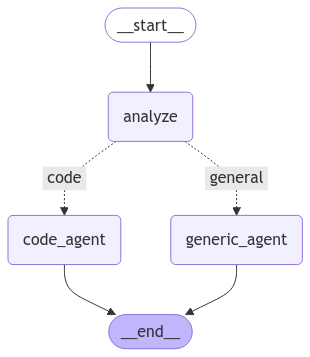

In [24]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [25]:
graph.invoke({"input" : "프롬프트란?"})

{'input': '프롬프트란?',
 'output': AIMessage(content='프롬프트는 컴퓨터 시스템에서 사용자에게 명령을 입력하도록 유도하는 화면이나 메시지를 말합니다. 주로 명령 프롬프트라고 불리며, 사용자가 컴퓨터에 명령을 입력할 수 있도록 하는 인터페이스 역할을 합니다.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 105, 'prompt_tokens': 39, 'total_tokens': 144, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run-db4376ee-4758-425b-ab78-8d0a4ca60c46-0', usage_metadata={'input_tokens': 39, 'output_tokens': 105, 'total_tokens': 144, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}),
 'decision': 'general'}

In [29]:
graph.invoke({"input" : "숫자 입력을 요청하고, 숫자가 아닌 경우 '잘못된 입력'이라는 메시지를 출력하는 코드를 작성해주세요."})

{'input': "숫자 입력을 요청하고, 숫자가 아닌 경우 '잘못된 입력'이라는 메시지를 출력하는 코드를 작성해주세요.",
 'output': AIMessage(content='코드를 작성하기 전에 어떤 언어를 사용할지 명확하게 해야 합니다. 여기서는 Python을 사용하여 코드를 작성하도록 하겠습니다.\n\nStep 1: 사용자로부터 숫자를 입력받습니다.\n```python\nnum = input("숫자를 입력하세요: ")\n```\n\nStep 2: 입력된 값이 숫자인지 확인합니다.\n```python\nif num.isdigit():\n    print("입력한 값은 숫자입니다.")\nelse:\n    print("잘못된 입력입니다.")\n```\n\n이제 두 단계를 합치면 다음과 같은 Python 코드가 됩니다.\n\n```python\nnum = input("숫자를 입력하세요: ")\n\nif num.isdigit():\n    print("입력한 값은 숫자입니다.")\nelse:\n    print("잘못된 입력입니다.")\n```\n\n이 코드를 실행하면 사용자가 입력한 값이 숫자인지 아닌지를 확인할 수 있습니다. 만약 숫자가 아닌 값을 입력하면 "잘못된 입력입니다."라는 메시지가 출력됩니다.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 264, 'prompt_tokens': 91, 'total_tokens': 355, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5